<a href="https://colab.research.google.com/github/maryisangediok/Bitcoin-Prediction-2022/blob/main/BitcoinPricePrediction2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

#FOLDERNAME = 'creditcard/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# load data
import pandas as pd
path = '/content/drive/MyDrive/btc-usd-max.csv'
data = pd.read_csv(path, index_col=0)

In [24]:
data.head(5)

,price,market_cap,total_volume
snapped_at,,,
2013-04-28 00:00:00 UTC,135.30,1.500518e+09,0.0
2013-04-29 00:00:00 UTC,141.96,1.575032e+09,0.0
2013-04-30 00:00:00 UTC,135.30,1.501657e+09,0.0
2013-05-01 00:00:00 UTC,117.00,1.298952e+09,0.0
2013-05-02 00:00:00 UTC,103.43,1.148668e+09,0.0


In [25]:
data.describe()

,price,market_cap,total_volume
count,3336.000000,3.335000e+03,3.336000e+03
mean,10578.755357,1.946524e+11,1.273077e+10
std,15922.365316,3.005564e+11,1.840861e+10
min,67.809000,7.713681e+08,0.000000e+00
25%,455.045225,6.601816e+09,9.089825e+07
50%,3906.972352,6.791402e+10,2.494279e+09
75%,10183.196885,1.824630e+11,2.274793e+10
max,67617.015545,1.278798e+12,1.788941e+11


In [26]:
# check for missing data
data.isnull().sum()

price           0
market_cap      1
total_volume    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


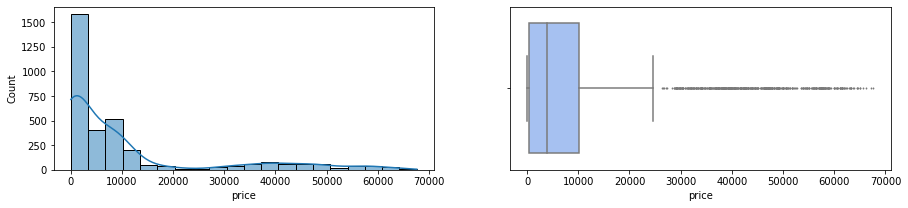

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


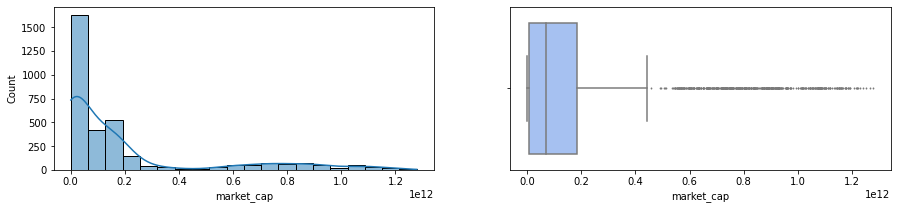

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


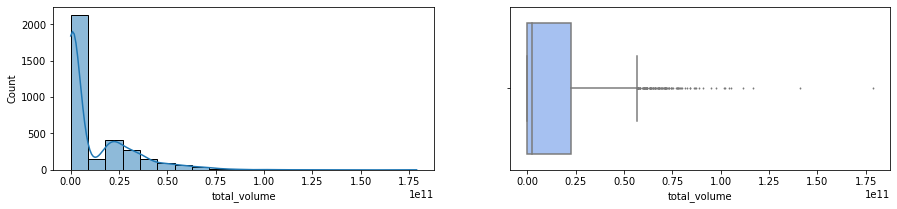

In [27]:
# check distribution of each feature
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
for i in data:
        fig, axs = plt.subplots(1,2,figsize=(15, 3))
        sns.histplot(data[i],bins=20, kde=True,ax=axs[0])
        sns.boxplot(data[i], ax = axs[1], color='#99befd', fliersize=1);
        plt.show()
        plt.close()

In [28]:
data=data.interpolate()
data.isnull().sum()

price           0
market_cap      0
total_volume    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


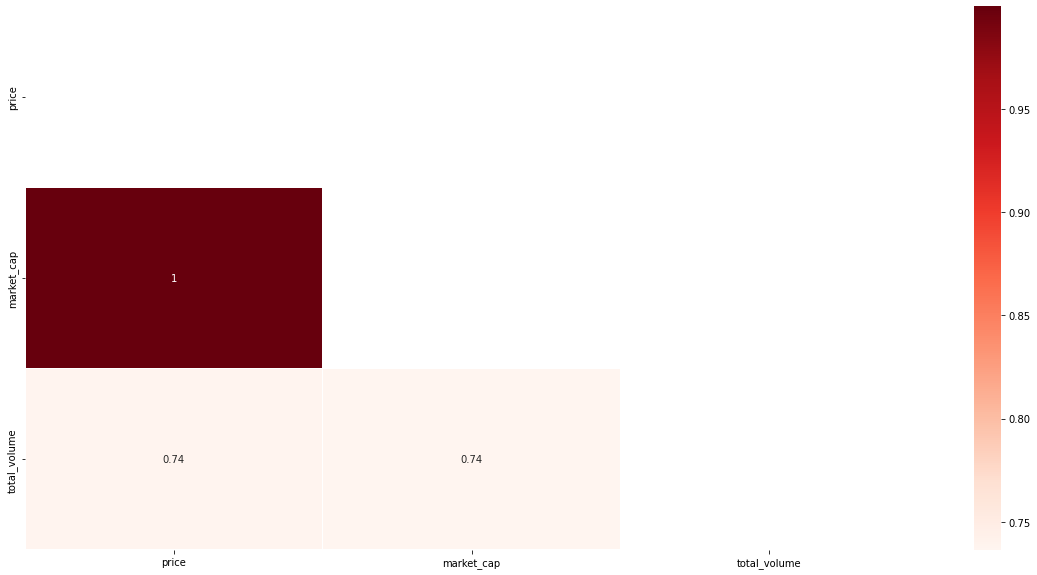

In [29]:
#check for correlation between features
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
sns.heatmap(data.corr(), annot=True, cmap="Reds", mask=mask, linewidth=0.5)
plt.show()

There is strong correlation between price and market cap

In [30]:
X = data.drop(['price'], axis=1)
y = data[['price']]

In [31]:
from sklearn.model_selection import train_test_split

def train_val_test_split(data, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data, y, 0.2)


In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(2001, 2) (2001, 1)
(668, 2) (668, 1)
(667, 2) (667, 1)


In [33]:
# feature scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "ss": StandardScaler
    }
    return scalers.get(scaler.lower())()
scaler = get_scaler('ss')
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)
X_val_ = scaler.transform(X_val)

y_train_ = scaler.fit_transform(y_train)
y_val_ = scaler.transform(y_val)
y_test_ = scaler.transform(y_test)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_)
train_targets = torch.Tensor(y_train_)
val_features = torch.Tensor(X_val_)
val_targets = torch.Tensor(y_val_)
test_features = torch.Tensor(X_test_)
test_targets = torch.Tensor(y_test_)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

myLSTM class initiates a LSTM module based on PyTorch's nn.Module class.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state of LSTMs to our desired output shape.

The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        
The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

       

In [35]:
class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        out = F.relu(out)
        out = self.fc(out)
        return out

In [36]:
def get_model(model, model_params):
    models = {"lstm": myLSTM }
    return models.get(model.lower())(**model_params)

Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function and provides a framework to train and validate the models, and to predict future values based on the models.

    Attributes:
        model (myLSTM): Model class created for the type of myLSTM
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained


The function train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the function completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses


The function train performs the model training

        The function takes DataLoaders for training and validation datasets, batch size for mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the function train_step for n_epochs times. If early stopping is enabled, then it  checks the stopping condition to decide whether the training needs to halt before n_epochs steps. 

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns


The function evaluate performs the model evaluation

        The function takes DataLoaders for the test dataset, batch size for mini-batch testing, and number of features as inputs. It iteratively predicts the target values and calculates losses. Then, it returns two lists that hold the predictions and the actual values.
This function assumes that the prediction from the previous step is available at the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.


The function plot_losses plots the calculated loss values for training and validation


In [37]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        self.model.train() # Sets model to train mode
        yhat = self.model(x) # Makes predictions
        loss = self.loss_fn(y, yhat) # Computes loss
        loss.backward() # Computes gradients
        self.optimizer.step() # Updates parameters and zeroes gradients
        self.optimizer.zero_grad()
        return loss.item() # Returns the loss

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=2):
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 50) | (epoch % 100 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=2):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        figure(figsize=(20, 10), dpi=80)
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/200] Training loss: 1.0122	 Validation loss: 2.8187
[2/200] Training loss: 0.8527	 Validation loss: 2.1555
[3/200] Training loss: 0.6795	 Validation loss: 0.7351
[4/200] Training loss: 0.3466	 Validation loss: 0.5181
[5/200] Training loss: 0.1303	 Validation loss: 2.9639
[6/200] Training loss: 0.0733	 Validation loss: 2.7764
[7/200] Training loss: 0.0434	 Validation loss: 1.9674
[8/200] Training loss: 0.0235	 Validation loss: 1.0631
[9/200] Training loss: 0.0238	 Validation loss: 0.5147
[10/200] Training loss: 0.0129	 Validation loss: 0.2330
[11/200] Training loss: 0.0234	 Validation loss: 0.1795
[12/200] Training loss: 0.0161	 Validation loss: 0.0969
[13/200] Training loss: 0.0941	 Validation loss: 0.0836
[14/200] Training loss: 0.0939	 Validation loss: 0.2292
[15/200] Training loss: 0.2495	 Validation loss: 1.0289
[16/200] Training loss: 0.0362	 Validation loss: 0.4861
[17/200] Training loss: 0.0380	 Validation loss: 0.0666
[18/200] Training loss: 0.0170	 Validation loss: 0.1550
[

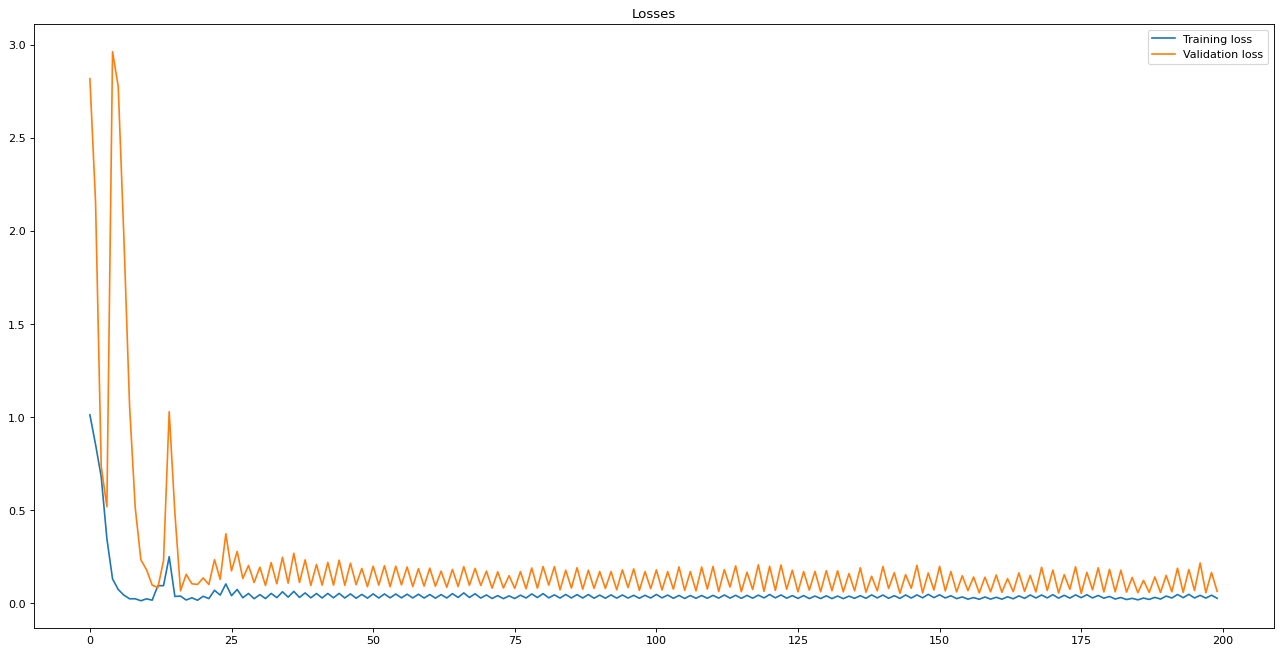

In [38]:
import torch.optim as optim
from datetime import datetime
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 256
layer_dim = 2
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-3

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [42]:
def inverse_transform(scaler, data, columns):
    for col in columns:
        data[col] = scaler.inverse_transform(data[col])
    return data


def format_predictions(predictions, values, data_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    data_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=data_test.head(len(vals)).index)
    data_result = data_result.sort_index()
    data_result = inverse_transform(scaler, data_result, [["value", "prediction"]])
    return data_result


data_result = format_predictions(predictions, values, X_test, scaler)
data_result

,value,prediction
snapped_at,,
2020-08-19 00:00:00 UTC,11949.611328,13547.752930
2020-08-20 00:00:00 UTC,11733.279297,13353.299805
2020-08-21 00:00:00 UTC,11861.836914,13546.083008
2020-08-22 00:00:00 UTC,11515.125000,13144.937500
2020-08-23 00:00:00 UTC,11676.385742,13375.995117
...,...,...
2022-06-13 00:00:00 UTC,26767.269531,21459.050781
2022-06-14 00:00:00 UTC,22525.769531,19634.150391
2022-06-15 00:00:00 UTC,22244.849609,20012.626953


In [40]:
data_result.columns

Index(['value', 'prediction'], dtype='object')

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(data):
    result_metrics = {'mae' : mean_absolute_error(data.value, data.prediction),
                      'rmse' : mean_squared_error(data.value, data.prediction) ** 0.5,
                      'r2' : r2_score(data.value, data.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(data_result)


Mean Absolute Error:        17246.549
Root Mean Squared Error:    20615.087290622854
R^2 Score:                  -0.9069162617219091
